In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Introduction
Customer churn is a problem every business faces. While the primary reasons for churn can differ by customer, there may be behavioral patterns or commonality in demographic attributes. Using a dataset for telecom churn, I will attempt to build a predictive model that can identify at-risk customers. 

This model can allow a company to take preventative action and reduce churn (i.e., improve revenue).

The data set is located in the link below

https://www.kaggle.com/blastchar/telco-customer-churn/download

# Approach

After loading and cleansing the data set,  I will conduct EDA to identify which features might be predictive of churn. I'll explore feature engineering using SelectKBest and PCA. I'll also try an oversampling method because of the class imbalance. I'll build several models and determine which performs best based on precision, recall, f1 score, and overall accuracy.

# Load Dataset

In [3]:
path = "file_location"
raw_df = pd.read_excel(path)

In [4]:
raw_df.info()
raw_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
customerID          7043 non-null object
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
tenure              7043 non-null int64
PhoneService        7043 non-null object
MultipleLines       7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
Contract            7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
Churn               7043 non-null object
dtypes: float64(1), int64(2), obj

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


# Clean Data

In [5]:
raw_df.shape

(7043, 21)

There are 7043 rows with 21 columns. There are no columns with null data. It looks like most of the data is categorical with monthly charges and tenure as the only continuous variables.

In [6]:
raw_df.nunique()

customerID          7043
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                73
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
TotalCharges        6531
Churn                  2
dtype: int64

In [7]:
raw_df.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [8]:
raw_df.describe(include = ['O'])

,customerID,gender,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,TotalCharges,Churn
count,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043.0,7043
unique,7043,2,2,2,2,3,3,3,3,3,3,3,3,3,2,4,6531.0,2
top,4710-FDUIZ,Male,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,20.2,No
freq,1,3555,3641,4933,6361,3390,3096,3498,3088,3095,3473,2810,2785,3875,4171,2365,11.0,5174


Senior citizens looks like it should be moved to categorical data for further analysis. Total charges looks like it is misclassified as a string and needs to be converted to a numerical variable. Additionally, Customer ID does not look to add much to the analysis (i.e., it is just a unique identifier). Therefore, I will drop it. Before making any changes, I'll make a copy of the data.

In [9]:
# copy data and clean up column names
model_df = raw_df.copy()
model_df.columns = map(str.lower, model_df.columns)

In [10]:
model_df['totalcharges'] = pd.to_numeric(model_df['totalcharges'], errors = 'coerce')
model_df['seniorcitizen'] = model_df['seniorcitizen'].map({1:'Yes', 0:"No"})
model_df.drop(['customerid'], axis=1, inplace=True)

In [11]:
model_df.describe(include = ['O'])

,gender,seniorcitizen,partner,dependents,phoneservice,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,churn
count,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043
unique,2,2,2,2,2,3,3,3,3,3,3,3,3,3,2,4,2
top,Male,No,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,No
freq,3555,5901,3641,4933,6361,3390,3096,3498,3088,3095,3473,2810,2785,3875,4171,2365,5174


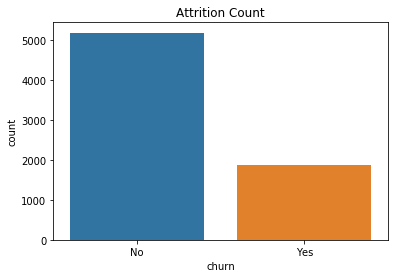

26.5% customers attrited


In [12]:
sns.countplot(model_df['churn'])
plt.title("Attrition Count")
plt.show()
print("{}% customers attrited".format(round(model_df['churn'][(model_df['churn'] == 'Yes')].count()/ model_df['churn'].count() * 100,1)))

26.5% of customers left the telecom company. There is a class imbalance which may require sampling techniques.  

# Exploring the Data

Will first look at the categorical data to see its relationship with churn. I'll then take a look at the numerical features.

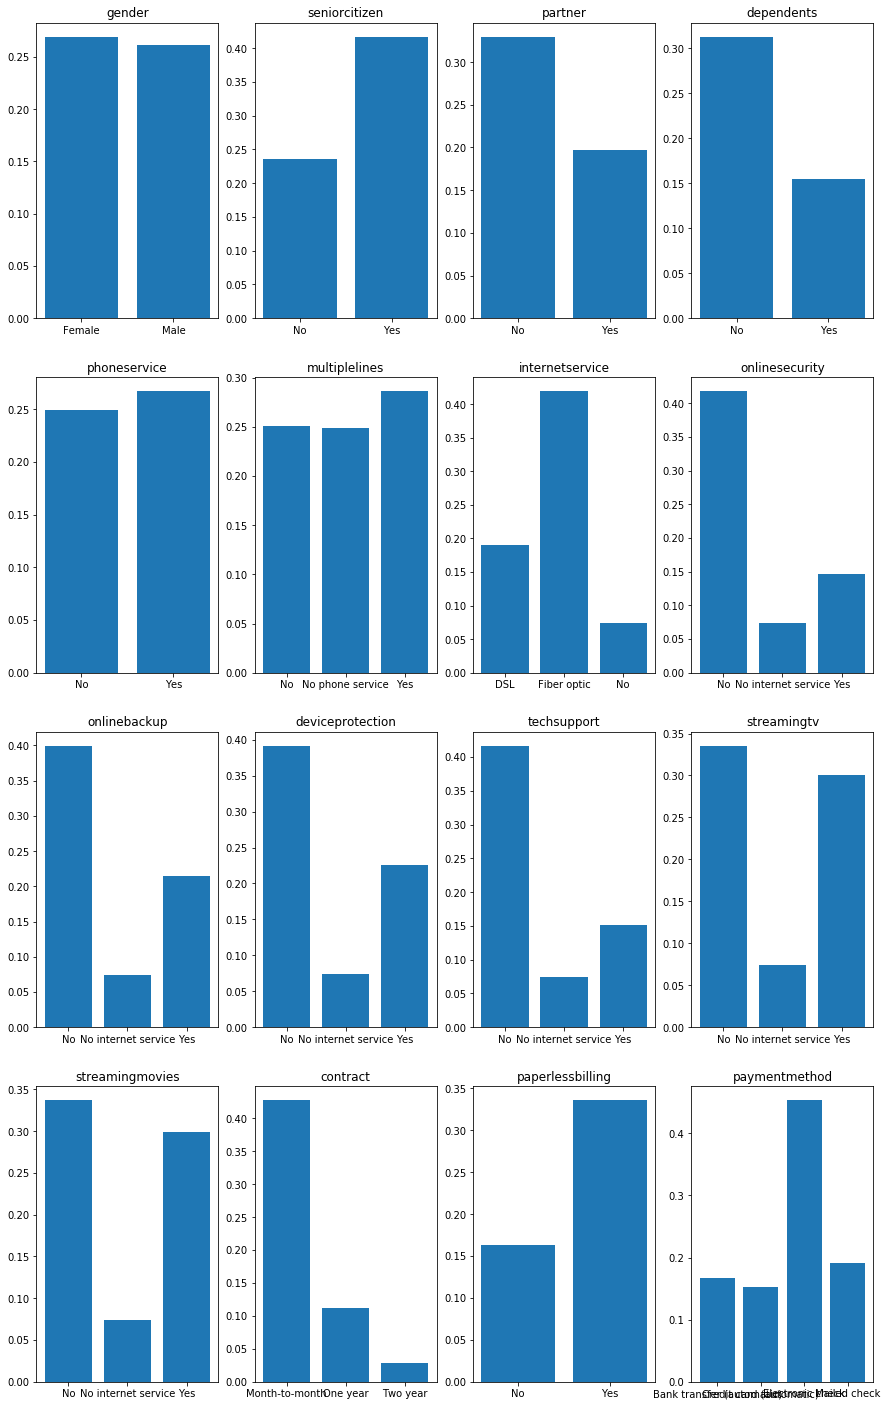

In [13]:
categorical_col = model_df.select_dtypes('object').columns


i = 1
plt.figure(figsize=(15,25))


for col in categorical_col[:-1]:
    plt.subplot(4,4,i)
    plt.title(model_df[col].name)
    d = pd.crosstab(index = model_df[col], columns = model_df.churn, normalize = 'index')
    plt.bar(d.index, d['Yes'])
    i += 1
    

A few of the categories need to be recoded before analyzing the attrition rates.

In [14]:
recode_var = {'No internet service': 'No',
             'No phone service': 'No'}
model_df.replace(recode_var, inplace=True)

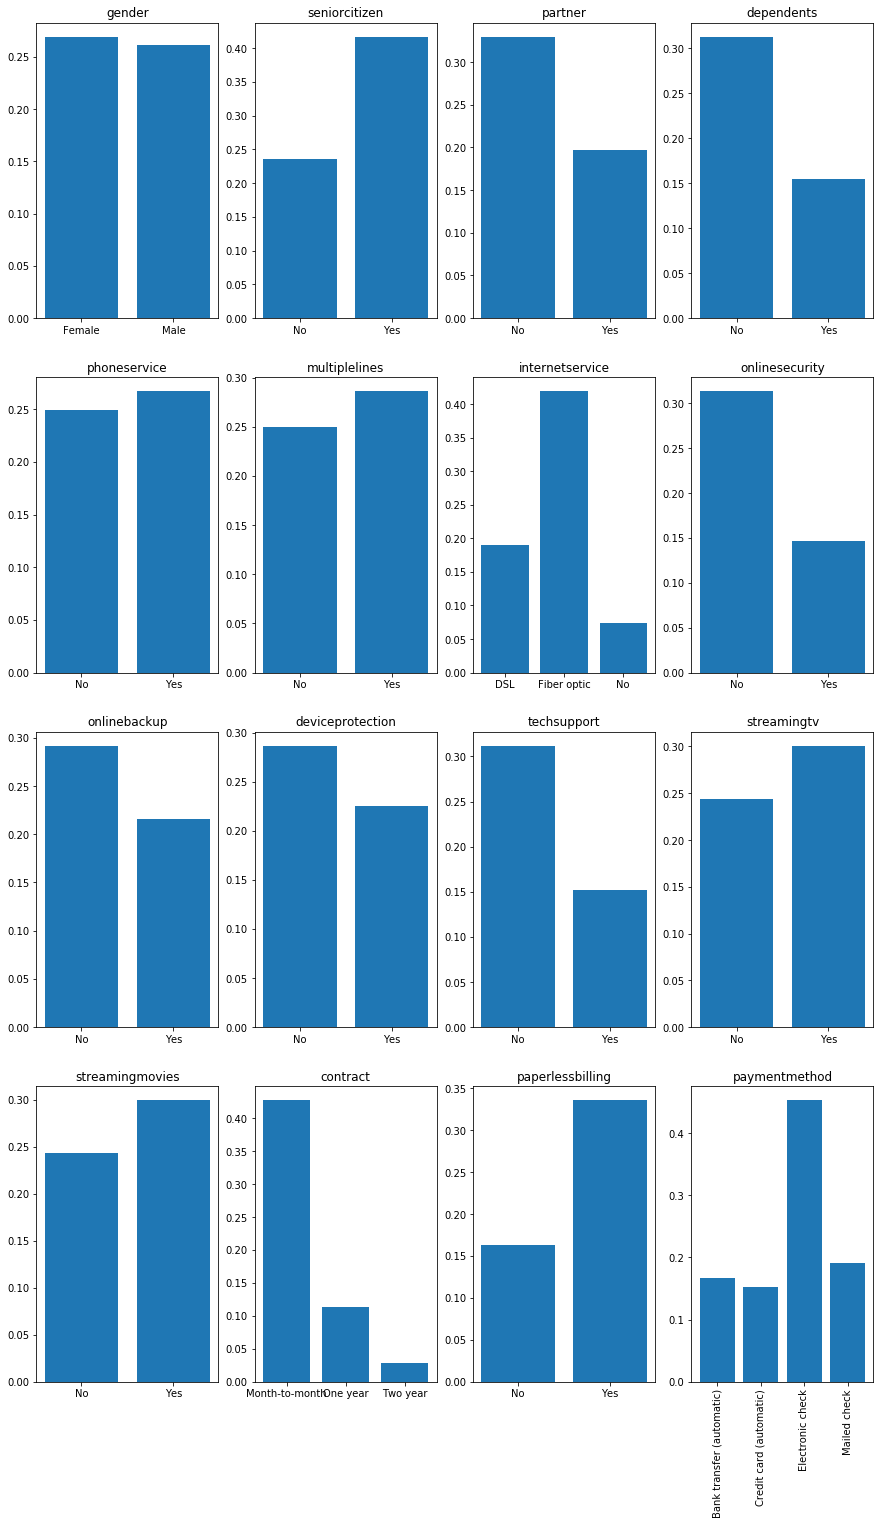

In [15]:
i = 1
plt.figure(figsize=(15,25))


for col in categorical_col[:-1]:
    if (model_df[col].name == 'paymentmethod'):
        plt.subplot(4,4,i)
        plt.title(model_df[col].name)
        d = pd.crosstab(index = model_df[col], columns = model_df.churn, normalize = 'index')
        plt.bar(d.index, d['Yes'])
        plt.xticks(rotation = 90)
        i += 1
    else:
        plt.subplot(4,4,i)
        plt.title(model_df[col].name)
        d = pd.crosstab(index = model_df[col], columns = model_df.churn, normalize = 'index')
        plt.bar(d.index, d['Yes'])
        i += 1

Top attributes that may influence churn:
- Senior citizen = yes
- No dependents
- Fiber optics for internet service
- no online sercurity
- no tech support
- month-to-month contract
- no paperless billing
- use electronic checks

Will now explore numerical data

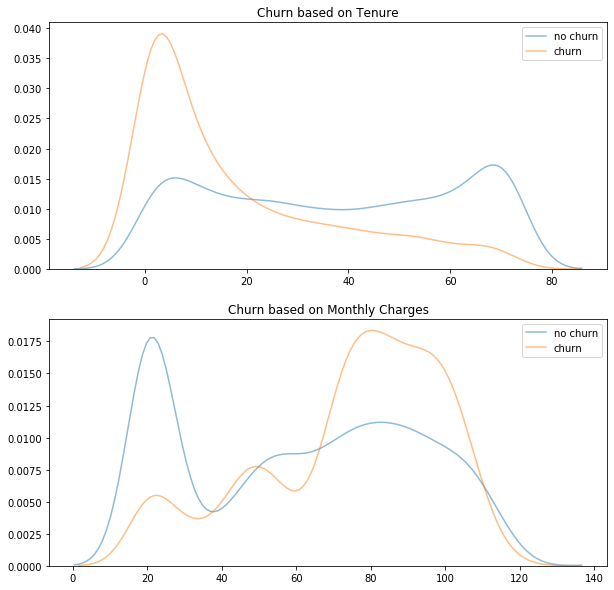

In [16]:
churn_no = model_df[(model_df['churn'] == 'No')]
churn_yes = model_df[(model_df['churn'] == 'Yes')]

plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.title("Churn based on Tenure")
sns.kdeplot(churn_no['tenure'], alpha =.5)
sns.kdeplot(churn_yes['tenure'], alpha =.5)
plt.legend(['no churn','churn'])

plt.subplot(2,1,2)
plt.title("Churn based on Monthly Charges")
sns.kdeplot(churn_no['monthlycharges'], alpha =.5)
sns.kdeplot(churn_yes['monthlycharges'], alpha =.5)
plt.legend(['no churn','churn'])


plt.show()

In [17]:
# check correlation between monthly and total charges
from scipy.stats import pearsonr
model_df['totalcharges'].fillna(0,inplace=True)
pearsonr(model_df['monthlycharges'], model_df['totalcharges'])

(0.6511738315787841, 0.0)

In [18]:
# will drop total charges as it has high correlation with monthly
model_df.drop('totalcharges', axis = 1, inplace=True)

In [19]:
# will create categorical data from two continuous variables 
tenure_cat = pd.cut(model_df['tenure'], bins = [0,22, model_df['tenure'].max()], labels=['Short', "Long"])
monthlycharges_cat = pd.cut(model_df['monthlycharges'], bins = [0, 65, model_df['monthlycharges'].max()], labels=['$65 or less', '$65+'])

In [20]:
model_df.insert(5, 'tenure_cat', tenure_cat)
model_df.insert(19, 'monthlycharges_cat', monthlycharges_cat)

In [21]:
model_df.drop(['tenure', 'monthlycharges'], axis = 1, inplace=True)

In [22]:
model_df.head()

,gender,seniorcitizen,partner,dependents,tenure_cat,phoneservice,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges_cat,churn
0,Female,No,Yes,No,Short,No,No,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,$65 or less,No
1,Male,No,No,No,Long,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,$65 or less,No
2,Male,No,No,No,Short,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,$65 or less,Yes
3,Male,No,No,No,Long,No,No,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),$65 or less,No
4,Female,No,No,No,Short,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,$65+,Yes


Each data point is now categorical and requires pre-processing prior to the modeling phase

# Pre-Processing

In [23]:
# convert categorical features 

model_df['churn'] = model_df['churn'].replace(['Yes', "No"], [1,0])
y = model_df['churn']
model_df.drop('churn', axis = 1, inplace=True)
X = pd.get_dummies(model_df)

In [24]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 40)

Because of the class imbalance noted above, I am going to use an oversampling technique (SMOTE) to create synthetic instances of customer churn

In [25]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(sampling_strategy='minority', random_state = 40)

# Fit the model to generate the data.
oversampled_X_train, oversampled_y_train = sm.fit_sample(X_train, y_train)
oversampled_X_train_df = pd.DataFrame(oversampled_X_train)
oversampled_X_train_df = X_train.columns

C:\Users\Raj.Mehta\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\Raj.Mehta\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.ensemble.bagging module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\Raj.Mehta\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: Th

In [26]:
oversampled_X_train_df

Index(['gender_Female', 'gender_Male', 'seniorcitizen_No', 'seniorcitizen_Yes',
       'partner_No', 'partner_Yes', 'dependents_No', 'dependents_Yes',
       'tenure_cat_Short', 'tenure_cat_Long', 'phoneservice_No',
       'phoneservice_Yes', 'multiplelines_No', 'multiplelines_Yes',
       'internetservice_DSL', 'internetservice_Fiber optic',
       'internetservice_No', 'onlinesecurity_No', 'onlinesecurity_Yes',
       'onlinebackup_No', 'onlinebackup_Yes', 'deviceprotection_No',
       'deviceprotection_Yes', 'techsupport_No', 'techsupport_Yes',
       'streamingtv_No', 'streamingtv_Yes', 'streamingmovies_No',
       'streamingmovies_Yes', 'contract_Month-to-month', 'contract_One year',
       'contract_Two year', 'paperlessbilling_No', 'paperlessbilling_Yes',
       'paymentmethod_Bank transfer (automatic)',
       'paymentmethod_Credit card (automatic)',
       'paymentmethod_Electronic check', 'paymentmethod_Mailed check',
       'monthlycharges_cat_$65 or less', 'monthlycharges_c

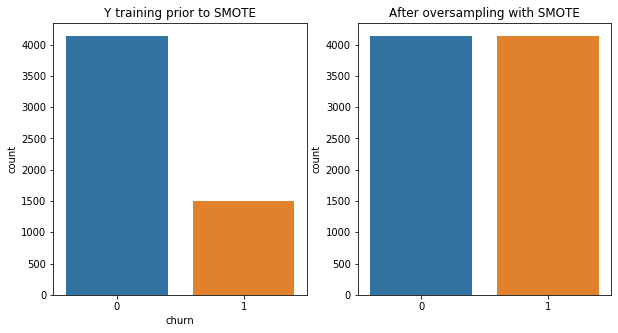

In [27]:
# training data before and after oversampling

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title("Y training prior to SMOTE")
sns.countplot(y_train)

plt.subplot(1,2,2)
plt.title("After oversampling with SMOTE")
sns.countplot(oversampled_y_train)
plt.show()

# Modeling Process

# Baseline Model

Before applying sampling techniques, feature engineering, and hyper parameter tuning, I am going to run a simple logistic regression

In [36]:
baseline_lr = LogisticRegression()

baseline_lr.fit(X_train,y_train)

model_eval(baseline_lr,X_test, y_test)



[[909 125]
 [176 199]]
              precision    recall  f1-score   support

           0       0.84      0.88      0.86      1034
           1       0.61      0.53      0.57       375

    accuracy                           0.79      1409
   macro avg       0.73      0.70      0.71      1409
weighted avg       0.78      0.79      0.78      1409

ROC_AUC: 0.705


# Select K Best

In [38]:
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif

selector = SelectKBest(chi2, k='all')

x_selectKBest = selector.fit(X_train, y_train)

df_score = pd.DataFrame(x_selectKBest.scores_)
df_columns = pd.DataFrame(X_train.columns)
featureScores = pd.concat([df_columns,df_score],axis=1)
featureScores.columns = ['Features','Score']  #naming the dataframe columns
print(featureScores.sort_values(by = 'Score', ascending = False))


                                   Features       Score
29                  contract_Month-to-month  436.713140
31                        contract_Two year  402.029521
36           paymentmethod_Electronic check  346.483408
8                          tenure_cat_Short  344.476471
15              internetservice_Fiber optic  308.951805
9                           tenure_cat_Long  252.355858
16                       internetservice_No  240.985446
30                        contract_One year  146.197197
38           monthlycharges_cat_$65 or less  141.143447
32                      paperlessbilling_No  119.915886
18                       onlinesecurity_Yes  115.142687
39                  monthlycharges_cat_$65+  113.077199
7                            dependents_Yes  112.066429
24                          techsupport_Yes  102.741962
3                         seniorcitizen_Yes   96.786730
35    paymentmethod_Credit card (automatic)   86.141117
33                     paperlessbilling_Yes   81

The top features look in line with what I had found in the EDA phase. With 40 features after encoding, I am going to use the top 10 going forward.

In [39]:
selectK = SelectKBest(chi2, k = 10)
X_features_kbest = selectK.fit(X_train, y_train)
X_features_oversampled = selectK.transform(oversampled_X_train)
X_test_kbest = selectK.transform(X_test)

mask = selectK.get_support()
new_features = X_train.columns[mask]

In [40]:
new_features

Index(['tenure_cat_Short', 'tenure_cat_Long', 'internetservice_Fiber optic',
       'internetservice_No', 'contract_Month-to-month', 'contract_One year',
       'contract_Two year', 'paperlessbilling_No',
       'paymentmethod_Electronic check', 'monthlycharges_cat_$65 or less'],
      dtype='object')

In [30]:
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn import tree
from sklearn.decomposition import PCA
from sklearn.svm import SVC
import time
from sklearn import metrics
from sklearn.metrics import confusion_matrix

# Logistic Regression Tuning

In [483]:
lr = LogisticRegression()

params = {}
params['penalty'] = ['l1','l2',None]
params['C']= [0.001, 0.01, 0.1, 1, 10, 100, 10000]
params['max_iter'] = [1000]

CV = GridSearchCV(lr, params,cv = 5,scoring = 'f1_weighted', n_jobs= -1)

In [484]:
start_time = time.time()
    
lr_model = CV.fit(X_features_oversampled, oversampled_y_train)

print("--- %s seconds ---" % (time.time() - start_time))
print(lr_model.best_params_)

--- 0.747473955154419 seconds ---
{'C': 0.01, 'max_iter': 1000, 'penalty': 'l2'}


In [526]:
model_eval(lr_model,X_test_kbest, y_test)

[[830 204]
 [139 236]]
              precision    recall  f1-score   support

           0       0.86      0.80      0.83      1034
           1       0.54      0.63      0.58       375

    accuracy                           0.76      1409
   macro avg       0.70      0.72      0.70      1409
weighted avg       0.77      0.76      0.76      1409

ROC_AUC: 0.716


# Support Vector Machine Tuning

In [633]:
svc = SVC()

params = {}
params['gamma'] = [0.01, 0.1, 0.5, 1, 'scale', 'auto']
params['C']= [0.001, 0.01, 0.1, 1, 10]
params['kernel'] = ['rbf', 'poly', 'linear']

CV = GridSearchCV(svc, params,cv = 5,scoring = 'f1_weighted', n_jobs= -1)

In [634]:
start_time = time.time()
    
svc_model = CV.fit(X_features_oversampled, oversampled_y_train)

print("--- %s seconds ---" % (time.time() - start_time))
print(svc_model.best_params_)

--- 982.081621170044 seconds ---
{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}


In [635]:
model_eval(svc_model,X_test_kbest, y_test)

[[740 294]
 [ 91 284]]
              precision    recall  f1-score   support

           0       0.89      0.72      0.79      1034
           1       0.49      0.76      0.60       375

    accuracy                           0.73      1409
   macro avg       0.69      0.74      0.69      1409
weighted avg       0.78      0.73      0.74      1409

ROC_AUC: 0.737


In [675]:
svc_adj = SVC(C =1E10, gamma = 1E10, kernel = 'rbf')

In [676]:
model = svc_adj.fit(X_features_oversampled, oversampled_y_train)

In [677]:
model_eval(model,X_test_kbest, y_test)

[[777 257]
 [111 264]]
              precision    recall  f1-score   support

           0       0.88      0.75      0.81      1034
           1       0.51      0.70      0.59       375

    accuracy                           0.74      1409
   macro avg       0.69      0.73      0.70      1409
weighted avg       0.78      0.74      0.75      1409

ROC_AUC: 0.728


# Decision Tree Tuning

In [246]:
dt = tree.DecisionTreeClassifier()

params = {}
params['max_depth'] = [2,4,6,8,None]
params['criterion']= ['gini','entropy']
params['max_features'] = [2,4,6,None]
params['class_weight'] = ['balanced', None]

CV = GridSearchCV(dt, params,cv = 5,scoring = 'f1_weighted', n_jobs= -1)



In [247]:
start_time = time.time()
    
dt_model = CV.fit(X_features_oversampled, oversampled_y_train)

print("--- %s seconds ---" % (time.time() - start_time))
print(dt_model.best_params_)

--- 0.5331120491027832 seconds ---
{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 8, 'max_features': 4}


In [527]:
model_eval(dt_model,X_test_kbest, y_test)

[[781 253]
 [111 264]]
              precision    recall  f1-score   support

           0       0.88      0.76      0.81      1034
           1       0.51      0.70      0.59       375

    accuracy                           0.74      1409
   macro avg       0.69      0.73      0.70      1409
weighted avg       0.78      0.74      0.75      1409

ROC_AUC: 0.73


# Random Forest Tuning

In [492]:
rfc = RandomForestClassifier()

params = {}
params['max_depth'] = [2,10,20,30,40, 50, None]
params['n_estimators'] = [100,200, 500,750, 1000]
params['criterion'] = ['gini', 'entropy']
params['max_features'] = ['sqrt', 'log2', 'auto']
params['min_samples_leaf'] = [2,5,10,15]
params['min_samples_split'] = [2,5,10,15]

CV = GridSearchCV(rfc, params,cv = 5,scoring = 'f1_weighted', n_jobs= -1)


In [493]:
start_time = time.time()
    
rfc_model = CV.fit(X_features_oversampled, oversampled_y_train)

print("--- %s seconds ---" % (time.time() - start_time))
print(rfc_model.best_params_)

--- 6584.584990978241 seconds ---
{'criterion': 'entropy', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 15, 'n_estimators': 100}


In [534]:
rfc_model.cv_results_

{'mean_fit_time': array([0.34, 0.68, 1.76, ..., 3.45, 5.13, 6.2 ]),
 'std_fit_time': array([0.01, 0.02, 0.03, ..., 0.07, 0.1 , 0.41]),
 'mean_score_time': array([0.04, 0.07, 0.16, ..., 0.32, 0.43, 0.49]),
 'std_score_time': array([0.  , 0.  , 0.  , ..., 0.02, 0.05, 0.04]),
 'param_criterion': masked_array(data=['gini', 'gini', 'gini', ..., 'entropy', 'entropy',
                    'entropy'],
              mask=[False, False, False, ..., False, False, False],
        fill_value='?',
             dtype=object),
 'param_max_depth': masked_array(data=[2, 2, 2, ..., None, None, None],
              mask=[False, False, False, ..., False, False, False],
        fill_value='?',
             dtype=object),
 'param_max_features': masked_array(data=['sqrt', 'sqrt', 'sqrt', ..., 'auto', 'auto', 'auto'],
              mask=[False, False, False, ..., False, False, False],
        fill_value='?',
             dtype=object),
 'param_min_samples_leaf': masked_array(data=[2, 2, 2, ..., 15, 15, 15],
   

In [87]:
model_eval(rfc_model,X_test_kbest, y_test)

[[780 254]
 [111 264]]
              precision    recall  f1-score   support

           0       0.88      0.75      0.81      1034
           1       0.51      0.70      0.59       375

    accuracy                           0.74      1409
   macro avg       0.69      0.73      0.70      1409
weighted avg       0.78      0.74      0.75      1409

ROC_AUC: 0.729


In [53]:
rfc_adj2 = RandomForestClassifier(criterion = 'entropy', max_depth = 10, max_features = 'sqrt', 
                                 min_samples_leaf = 2, n_estimators = 50)

In [54]:
rfc_adj2.fit(X_features_oversampled, oversampled_y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=10, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [43]:
feature_importances = pd.DataFrame(rfc_adj2.feature_importances_, index = new_features,columns=['importance']).sort_values('importance',ascending=False)

In [44]:
feature_importances

,importance
contract_Month-to-month,0.259358
contract_Two year,0.134366
paymentmethod_Electronic check,0.126276
internetservice_Fiber optic,0.122800
tenure_cat_Short,0.097991
tenure_cat_Long,0.081777
contract_One year,0.051627
internetservice_No,0.044254
monthlycharges_cat_$65 or less,0.042341
paperlessbilling_No,0.039211


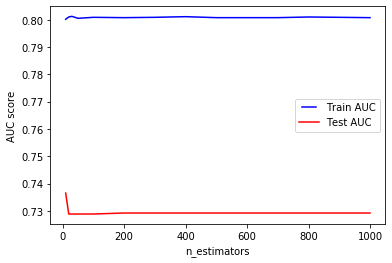

In [65]:
n_estimators = [10,20,30,50, 100, 200,300,400,500,600,700,800,900,1000]
train_results = []
test_results = []
for estimator in n_estimators:
    rf = RandomForestClassifier(n_estimators=estimator, criterion = 'entropy', max_depth = 10, max_features = 'sqrt', 
                                 min_samples_leaf = 2)
    rf.fit(X_features_oversampled, oversampled_y_train)
    train_pred = rf.predict(X_features_oversampled)
    false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(oversampled_y_train, train_pred)
    roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = rf.predict(X_test_kbest)
    false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_test, y_pred)
    roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(n_estimators, train_results, 'b', label= 'Train AUC')
line2, = plt.plot(n_estimators, test_results, 'r', label= 'Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('n_estimators')
plt.show()

# Gradient Boosting Tuning

In [257]:
gbc = GradientBoostingClassifier()

params = {}
params['loss'] = ['deviance', 'exponential']
params['n_estimators'] = [100,500,1000,10000]
params['max_features'] = ['sqrt', 'log2']
params['max_depth'] = [2,4,6,8, 10, 12]

CV = GridSearchCV(gbc, params,cv = 5,scoring = 'f1_weighted', n_jobs= -1)

In [258]:
start_time = time.time()
    
gbc_model = CV.fit(X_features_oversampled, oversampled_y_train)

print("--- %s seconds ---" % (time.time() - start_time))
print(gbc_model.best_params_)

--- 2416.0796570777893 seconds ---
{'loss': 'exponential', 'max_depth': 4, 'max_features': 'log2', 'n_estimators': 500}


In [260]:
model_eval(gbc_model,X_test_kbest, y_test)

[[782 252]
 [112 263]]
              precision    recall  f1-score   support

           0       0.87      0.76      0.81      1034
           1       0.51      0.70      0.59       375

    accuracy                           0.74      1409
   macro avg       0.69      0.73      0.70      1409
weighted avg       0.78      0.74      0.75      1409

AUC: 0.729


# PCA for Feature Engineering

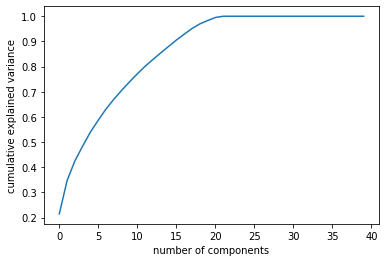

In [70]:
pca_model = PCA()

pca = pca_model.fit(X_train)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

15 components explains almost all of the variance

In [74]:
pca_model = PCA(15)
pca_model.fit(oversampled_X_train)

X_train_pca = pca_model.transform(oversampled_X_train)
X_test_pca = pca_model.transform(X_test)

# Support Vector Machine PCA Tuning

In [72]:
svc_pca = SVC()

params = {}
params['gamma'] = [0.0001, 0.0005, 0.001, 0.005]
params['C']= [0.001, 0.01, 0.1, 1, 10, 100, 1000]

CV = GridSearchCV(svc_pca, params,cv = 5,scoring = 'f1_weighted', n_jobs= -1)

In [75]:
start_time = time.time()
    
svc_pca_model = CV.fit(X_train_pca, oversampled_y_train)

print("--- %s seconds ---" % (time.time() - start_time))
print(svc_pca_model.best_params_)

--- 54.23049736022949 seconds ---
{'C': 100, 'gamma': 0.0001}


In [76]:
model_eval(svc_pca_model,X_test_pca, y_test)

[[885 149]
 [160 215]]
              precision    recall  f1-score   support

           0       0.85      0.86      0.85      1034
           1       0.59      0.57      0.58       375

    accuracy                           0.78      1409
   macro avg       0.72      0.71      0.72      1409
weighted avg       0.78      0.78      0.78      1409

ROC_AUC: 0.715


# Decision Tree PCA Tuning

In [77]:
dt_pca = tree.DecisionTreeClassifier()

params = {}
params['max_depth'] = [2,4,6,8,None]
params['criterion']= ['gini','entropy']
params['max_features'] = [2,4,6,None]
params['class_weight'] = ['balanced', None]

CV = GridSearchCV(dt_pca, params,cv = 5,scoring = 'f1_weighted', n_jobs= -1)



In [78]:
start_time = time.time()
    
dt_pca_model = CV.fit(X_train_pca, oversampled_y_train)

print("--- %s seconds ---" % (time.time() - start_time))
print(dt_pca_model.best_params_)

--- 4.788768529891968 seconds ---
{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 6, 'max_features': 2}


In [292]:
model_eval(dt_pca_model,X_test_pca, y_test)

[[939  95]
 [223 152]]
              precision    recall  f1-score   support

           0       0.81      0.91      0.86      1034
           1       0.62      0.41      0.49       375

    accuracy                           0.77      1409
   macro avg       0.71      0.66      0.67      1409
weighted avg       0.76      0.77      0.76      1409

AUC: 0.657


# Random Forest PCA Tuning

In [79]:
rfc_pca = RandomForestClassifier()

params = {}
params['max_depth'] = [2,4,6,8, None]
params['n_estimators'] = [100,500,1000,10000]
params['criterion'] = ['gini', 'entropy']
params['max_features'] = ['sqrt', 'log2']

CV = GridSearchCV(rfc_pca, params,cv = 5,scoring = 'f1_weighted', n_jobs= -1)


In [301]:
start_time = time.time()
    
rfc_pca_model = CV.fit(X_train_pca, oversampled_y_train)

print("--- %s seconds ---" % (time.time() - start_time))
print(rfc_pca_model.best_params_)

--- 3873.710329055786 seconds ---
{'criterion': 'gini', 'max_depth': None, 'max_features': 'log2', 'n_estimators': 100}


In [309]:
model_eval(rfc_pca_model,X_test_pca, y_test)

[[876 158]
 [185 190]]
              precision    recall  f1-score   support

           0       0.83      0.85      0.84      1034
           1       0.55      0.51      0.53       375

    accuracy                           0.76      1409
   macro avg       0.69      0.68      0.68      1409
weighted avg       0.75      0.76      0.75      1409

AUC: 0.677


# Gradient Boosting PCA Tuning

In [330]:
gbc_pca = GradientBoostingClassifier()

params = {}
params['loss'] = ['deviance', 'exponential']
params['n_estimators'] = [100,500,1000,10000]
params['max_features'] = ['sqrt', 'log2']
params['max_depth'] = [2,4,6,8, 10, 12]

CV = GridSearchCV(gbc_pca, params,cv = 5,scoring = 'f1_weighted', n_jobs= -1)

In [331]:
start_time = time.time()
    
gbc_pca_model = CV.fit(X_train_pca, oversampled_y_train)

print("--- %s seconds ---" % (time.time() - start_time))
print(gbc_pca_model.best_params_)

--- 6478.992461442947 seconds ---
{'loss': 'deviance', 'max_depth': 2, 'max_features': 'log2', 'n_estimators': 500}


In [332]:
model_eval(gbc_pca_model,X_test_pca, y_test)

[[868 166]
 [169 206]]
              precision    recall  f1-score   support

           0       0.84      0.84      0.84      1034
           1       0.55      0.55      0.55       375

    accuracy                           0.76      1409
   macro avg       0.70      0.69      0.69      1409
weighted avg       0.76      0.76      0.76      1409

AUC: 0.694


# Model Results

In [86]:
model1 = model_comparison("Baseline_LR", baseline_lr,X_test, y_test)
model2 = model_comparison("LR_KBest",lr_model,X_test_kbest, y_test)
model3 = model_comparison("SVC_KBest", svc_model,X_test_kbest, y_test)
model4 = model_comparison("DT_KBest", dt_model,X_test_kbest, y_test)
model5 = model_comparison("RFC_KBest", rfc_model,X_test_kbest, y_test)
model6 = model_comparison("GBC_KBest", gbc_model,X_test_kbest, y_test)
model7 = model_comparison("SVC_PCA",svc_pca_model,X_test_pca, y_test)
model8 = model_comparison("DT_PCA", dt_pca_model,X_test_pca, y_test)
model9 = model_comparison("RFC_PCA", rfc_pca_model,X_test_pca, y_test)
model10 = model_comparison("GBC_PCA", gbc_pca_model,X_test_pca, y_test)

model_results = pd.concat([model1, 
            model2,
            model3,
            model4,
            model5,
            model6,
            model7,
            model8,
            model9,
            model10])
           

In [580]:
model_results
#model_results.to_csv('mode;_results.csv', index=False)

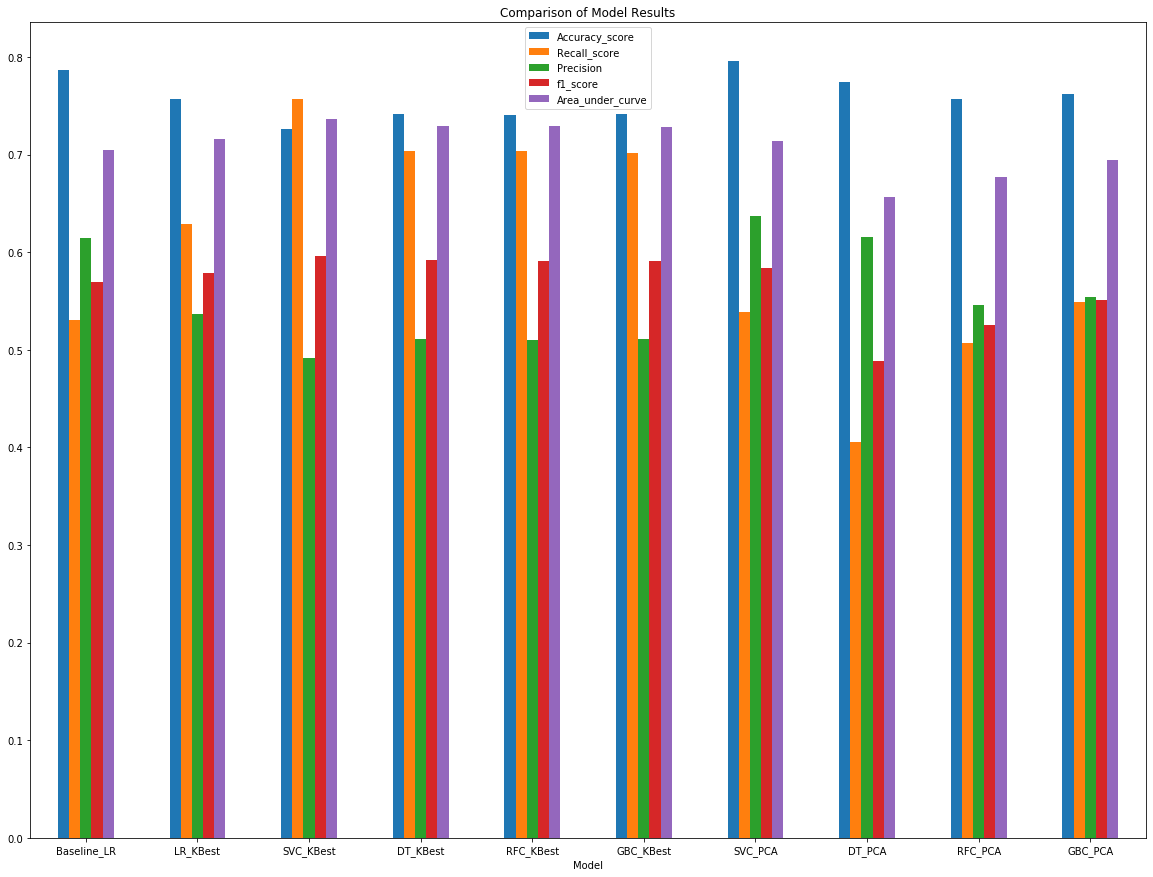

In [519]:
ax = model_results.set_index('Model').plot(kind='bar', figsize = (20,15), title = "Comparison of Model Results", rot = 0)


After running 10 models with trying to maximize the f1 weighted score, the support vector machine classifier with select K best for feature engineering offers the most promising results. In a churn problem with such class imbalance, accuracy by itself isn't a useful measure. While the baseline logistic regression model had the highest accuracy score, the recall score was quite low. A model that has many false negatives could be detrimental so I believe the SVC offers the best combination. The other consideration is the time it takes to train the model. Both the Random Forest Classifer and Gradient Boosting Classifier took 4-5 hours to train due the hyper paramater optimization. 

There was a 3% improvement in the AUC score for the SVC from the baseline model. In order to improve the model, I would try out different sampling techniques other than SMOTE. I would also look to conduct more feature engineering.  

# Helper Functions

In [34]:
# model evaluation function

def model_eval(model, x_test, y_test):
    y_predict = model.predict(x_test)
    confusion = confusion_matrix(y_test, y_predict)
    print(confusion)
    print(metrics.classification_report(y_test, y_predict))
    print("ROC_AUC:" ,round(metrics.roc_auc_score(y_test, y_predict),3))
    
    

In [35]:
def model_comparison(name, model, x_test, y_test):
    y_predict = model.predict(x_test)
    model_auc = metrics.roc_auc_score(y_test, y_predict)
    precision = metrics.precision_score(y_test, y_predict)
    recall = metrics.recall_score(y_test, y_predict)
    f1 = metrics.f1_score(y_test, y_predict)
    accuracy = metrics.accuracy_score(y_test, y_predict)
    
    df = pd.DataFrame({"Model"           : [name],
                       "Accuracy_score"  : [accuracy],
                       "Recall_score"    : [recall],
                       "Precision"       : [precision],
                       "f1_score"        : [f1],
                       "Area_under_curve": [model_auc],
                      })
    return df

In [49]:
import itertools
from sklearn.metrics import confusion_matrix
# confusions matrix
#Evaluation of Model - Confusion Matrix Plot
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 verticalalignment = 'baseline',
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


